# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation (which is in contrast to traditional image processing, where the filters are designed by an expert).

In [1]:
# This cell is finished

from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()
# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [2]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image,gaussFilter)
filterResponseSobelX = signal.convolve2d(image,sobelX)
filterResponseSobelY = signal.convolve2d(image,sobelY)

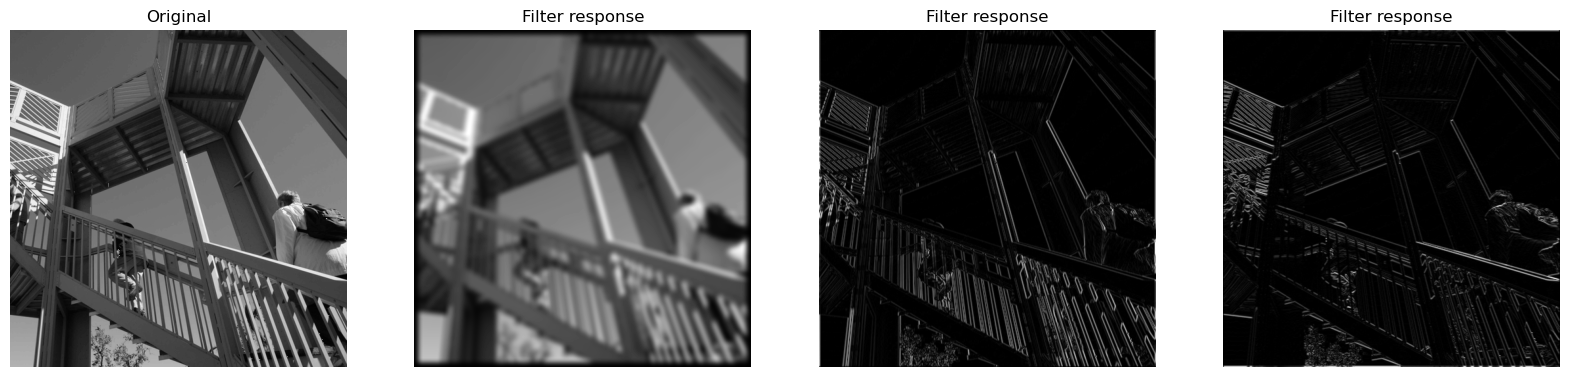

In [3]:
import matplotlib.pyplot as plt

# Show filter responses
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()
plt.show()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?
    
Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

Question 3: What is the size of the different filters?

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?


In [4]:
# Q1
# Gaussian core filter the lower frequent signal. SobelX shows the grident on vertical level whereas SobelY shows the gradient on horizontal level.
# Q2
# The original size is 512*512. When printing the shape of image, we can only see 512*512, so the number of channel is 1.
# Q3
# The gaussian filter is 15*15 whereas the other two are 3*3
# Q4
# It will be the same as original image.
# Q5
# The size will be size of image minus the size of filter. e.g. image (10*10) filter(3*3), then the result would be (7*7)
# Q6
# Because the size of image will keep going to smaller one, finally it may disappear with many layers.

In [5]:
# Your code for checking sizes of image and filter responses
filterResponseGauss = signal.convolve2d(image,gaussFilter,mode='valid')
filterResponseSobelX = signal.convolve2d(image,sobelX,mode='valid')
filterResponseSobelY = signal.convolve2d(image,sobelY,mode='valid')
print(image.shape)

(512, 512)


##  Part 3: Get a graphics card

Skip this part if you run on a CPU (recommended)

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [6]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)


import tensorflow.keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

##  Part 4: How fast is the graphics card?

Question 7: Why are the filters used for a color image of size 7 x 7 x 3, and not 7 x 7 ? 

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

Question 9: Do you think that a graphics card, compared to the CPU, is equally faster for convolving a batch of 1,000 images, compared to convolving a batch of 3 images? Motivate your answer.

In [7]:
# Q7
# Colored images are usually consist of three channels corresponding to RGB. 
# Q8
# 'Conv2D' can deal with multiple channels whereas signal.convolve2d can only tackle with singal layer.
# Q9
# The more images, the faster GPU will be compared with CPU. GPU is designed to calculate by parallel. So both the calculation speed of single equation and number of parallel are better than CPU.
# So when the number of images increase, the gap between parallel capacity will show up.

from tensorflow import keras##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [8]:
from tensorflow.keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

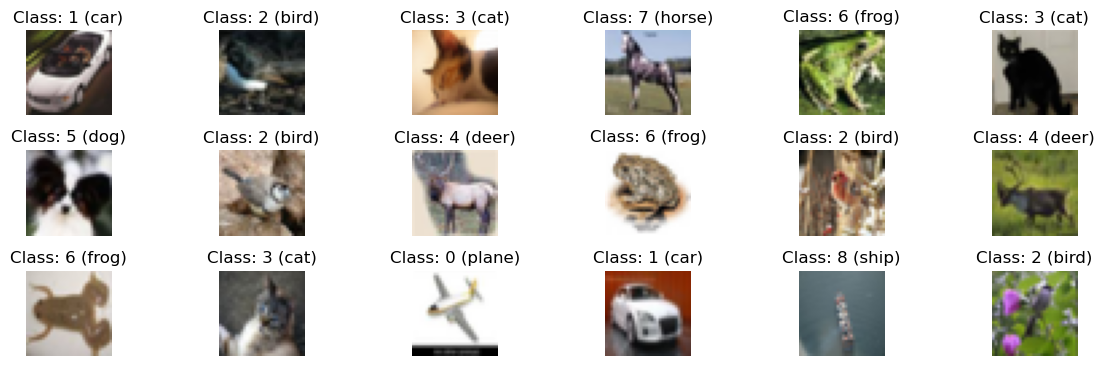

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [10]:
from sklearn.model_selection import train_test_split
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=5)
# Print the size of training data, validation data and test data


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [11]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/api/utils/python_utils/#to_categorical-function

In [12]:
from tensorflow.keras.utils import to_categorical

# Print shapes before converting the labels
print('Ytrain: ',Ytrain.shape)
print('Yval: ',Yval.shape)
print('Ytest: ',Ytest.shape)

Ytrain = to_categorical(Ytrain, num_classes=None, dtype="int")
Yval = to_categorical(Yval, num_classes=None, dtype="int")
Ytest = to_categorical(Ytest, num_classes=None, dtype="int")


# Your code for converting Ytrain, Yval, Ytest to categorical


# Print shapes after converting the labels
print('after converting')
print('Ytrain: ',Ytrain.shape)
print('Yval: ',Yval.shape)
print('Ytest: ',Ytest.shape)


Ytrain:  (7500, 1)
Yval:  (2500, 1)
Ytest:  (2000, 1)
after converting
Ytrain:  (7500, 10)
Yval:  (2500, 10)
Ytest:  (2000, 10)


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/api/layers/core_layers/dense/ and https://keras.io/api/layers/reshaping_layers/flatten/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

In [13]:
from numpy.random import seed

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import *


def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):
    seed(123)
    # Setup a sequential model
    model = Sequential()
    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(n_filters,3,padding = 'same',input_shape=input_shape[1:],activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='valid'))
    
    for i in range(n_conv_layers-1):
        model.add(Conv2D(n_filters*(2**(i+1)),3,activation='relu',padding = 'same'))
        model.add(BatchNormalization()) 
        if use_dropout == True:
            model.add(Dropout(0.25))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='valid'))
    
    model.add(Flatten())
    
    for i in range(n_dense_layers):
        model.add(Dense(n_nodes,activation='relu'))
        model.add(BatchNormalization())
        if use_dropout == True:
            model.add(Dropout(0.25))   
    # Add final dense layer
    model.add(Dense(10,activation='softmax'))
    # Compile model
    optim = Adam(lr=learning_rate)
    model.compile(optimizer=optim,loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [15]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

## 2 convolutional layers, no intermediate dense layers

In [16]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape

# Build model
model1 = build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval))

Epoch 1/20
75/75 [==============================] - 8s 28ms/step - loss: 3.8424 - accuracy: 0.2678 - val_loss: 1.9391 - val_accuracy: 0.3440
Epoch 2/20
75/75 [==============================] - 0s 5ms/step - loss: 1.6906 - accuracy: 0.4525 - val_loss: 1.5674 - val_accuracy: 0.4448
Epoch 3/20
75/75 [==============================] - 0s 6ms/step - loss: 1.2576 - accuracy: 0.5605 - val_loss: 1.5872 - val_accuracy: 0.4064
Epoch 4/20
75/75 [==============================] - 0s 5ms/step - loss: 1.1212 - accuracy: 0.6002 - val_loss: 1.4430 - val_accuracy: 0.4944
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 1.0283 - accuracy: 0.6450 - val_loss: 1.3415 - val_accuracy: 0.5288
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: 0.8997 - accuracy: 0.6818 - val_loss: 1.3712 - val_accuracy: 0.5428
Epoch 7/20
75/75 [==============================] - 0s 5ms/step - loss: 0.8391 - accuracy: 0.7070 - val_loss: 1.3578 - val_accuracy: 0.5492
Epoch 8/20
75/75 [=

In [17]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 2.9166
Test accuracy: 0.5325


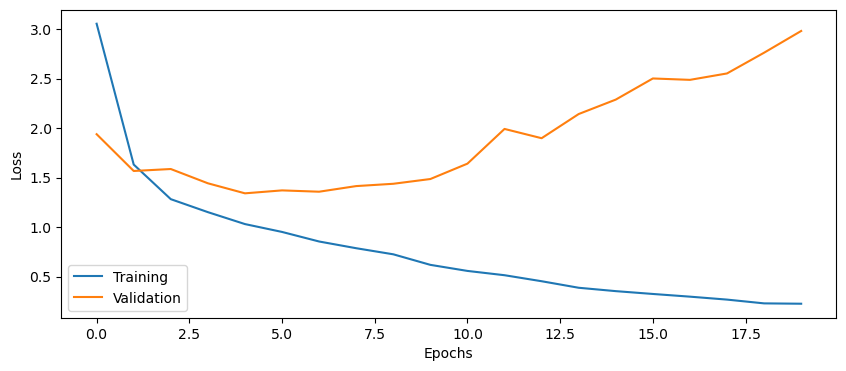

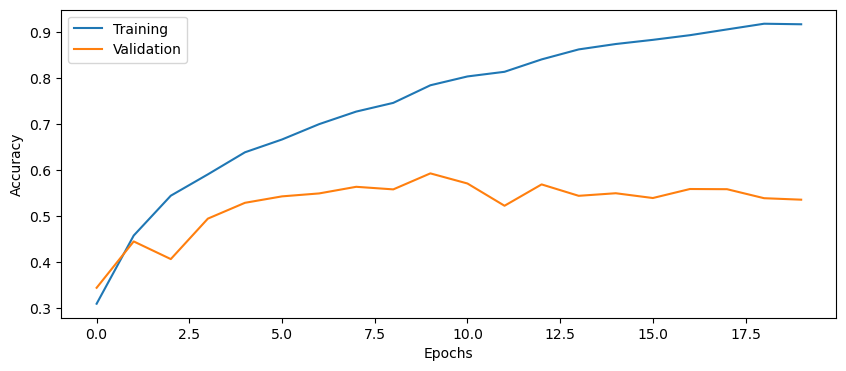

In [18]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance

Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 

Question 10: How big is the difference between training and test accuracy?

Question 11: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

In [19]:
# Q10 
# At the beginning ,both of them increase. But later only train accuracy increases and test accuracy keep stable. Finally, the training accuracy is 
# almost two times higher than training accuracy

# Q11
# Now the data is a picture with three channels, it's much larger than before

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [20]:
batch_size = 100
epochs = 20
input_shape = Xtrain.shape

# Build model
model2 = build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history2 = model2.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval))

Epoch 1/20
75/75 [==============================] - 1s 8ms/step - loss: 1.9054 - accuracy: 0.3428 - val_loss: 2.1802 - val_accuracy: 0.2728
Epoch 2/20
75/75 [==============================] - 1s 7ms/step - loss: 1.2796 - accuracy: 0.5427 - val_loss: 2.1809 - val_accuracy: 0.2884
Epoch 3/20
75/75 [==============================] - 1s 7ms/step - loss: 1.0419 - accuracy: 0.6187 - val_loss: 2.0180 - val_accuracy: 0.3736
Epoch 4/20
75/75 [==============================] - 1s 7ms/step - loss: 0.8169 - accuracy: 0.7149 - val_loss: 1.5447 - val_accuracy: 0.5108
Epoch 5/20
75/75 [==============================] - 1s 7ms/step - loss: 0.6701 - accuracy: 0.7768 - val_loss: 1.3593 - val_accuracy: 0.5732
Epoch 6/20
75/75 [==============================] - 1s 7ms/step - loss: 0.4916 - accuracy: 0.8325 - val_loss: 1.4763 - val_accuracy: 0.5848
Epoch 7/20
75/75 [==============================] - 0s 7ms/step - loss: 0.3676 - accuracy: 0.8797 - val_loss: 1.7880 - val_accuracy: 0.5800
Epoch 8/20
75/75 [==

In [21]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 2.7779
Test accuracy: 0.5780


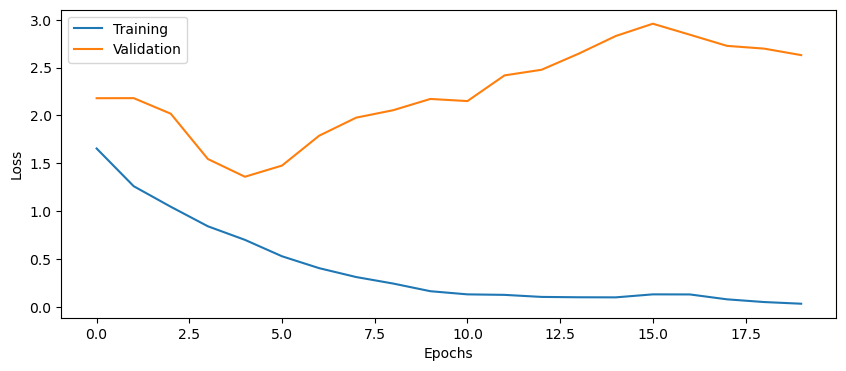

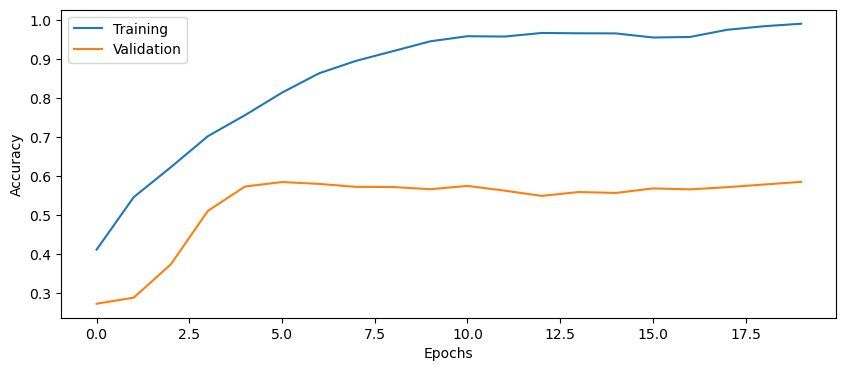

In [22]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [23]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape

# Build model
model3 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history3 = model3.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval)) 

Epoch 1/20
75/75 [==============================] - 1s 11ms/step - loss: 1.9303 - accuracy: 0.3229 - val_loss: 2.3806 - val_accuracy: 0.2396
Epoch 2/20
75/75 [==============================] - 1s 9ms/step - loss: 1.3961 - accuracy: 0.4876 - val_loss: 1.7487 - val_accuracy: 0.3912
Epoch 3/20
75/75 [==============================] - 1s 8ms/step - loss: 1.1662 - accuracy: 0.5808 - val_loss: 1.3321 - val_accuracy: 0.5276
Epoch 4/20
75/75 [==============================] - 1s 8ms/step - loss: 0.9809 - accuracy: 0.6432 - val_loss: 1.5108 - val_accuracy: 0.5268
Epoch 5/20
75/75 [==============================] - 1s 8ms/step - loss: 0.8363 - accuracy: 0.7063 - val_loss: 1.5131 - val_accuracy: 0.5488
Epoch 6/20
75/75 [==============================] - 1s 8ms/step - loss: 0.6560 - accuracy: 0.7755 - val_loss: 1.6221 - val_accuracy: 0.5580
Epoch 7/20
75/75 [==============================] - 1s 8ms/step - loss: 0.5634 - accuracy: 0.8072 - val_loss: 1.7580 - val_accuracy: 0.5636
Epoch 8/20
75/75 [=

In [24]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 2.2334
Test accuracy: 0.6045


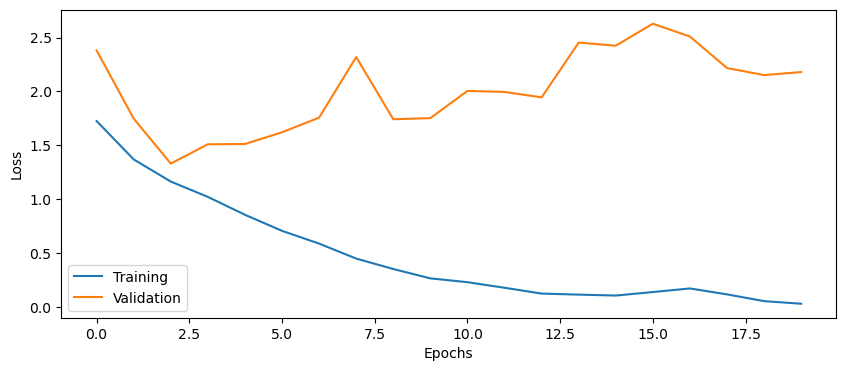

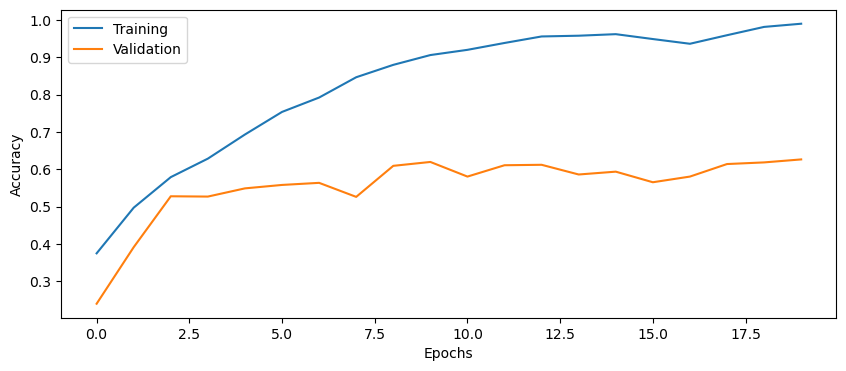

In [25]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 12: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

Question 13: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 

Question 14: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

Question 15: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

Question 16: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

Question 17: How does MaxPooling help in reducing the number of parameters to train?

In [ ]:
# Q12
# 124180 trainable parameters

# Q13
# the input size is (number of images,image width,image height,number of channel)
# the output size is (number of images,image width,image height,number of channel)
# Q14
# Yes
# Q15
# The number of output channel will equal to the number of filters,so, 128
# Q16
# Because the number of channel in each layer is different. The number of channel is decided by previous layer.
# Assume we have a conv2D with 8 filters ,the size of core is 5*5, the channel of input data is 32
# then the total number of coefficients is (5*5*32+1)*8
# Now there is a same conv2D just next to the conv2D we just talk about
# Then the number of coefficients will be (5*5*8+1)*8
# Q17
# MaxPooling will extract the maximum number in a block.In this way, it will reduce the height and weight of matrix,then reduce the number of coefficients.

In [1]:
(3*3*3+1)*16

448

In [55]:
# Print network architecture
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)         

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 18: How much did the test accuracy improve with dropout, compared to without dropout?

Question 19: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?


## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [30]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape

# Build model
model4 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history4 = model4.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xval,Yval)) 

Epoch 1/20
75/75 [==============================] - 1s 11ms/step - loss: 2.1677 - accuracy: 0.2511 - val_loss: 1.9478 - val_accuracy: 0.2868
Epoch 2/20
75/75 [==============================] - 1s 9ms/step - loss: 1.5875 - accuracy: 0.4079 - val_loss: 2.2235 - val_accuracy: 0.2704
Epoch 3/20
75/75 [==============================] - 1s 9ms/step - loss: 1.4455 - accuracy: 0.4640 - val_loss: 1.8821 - val_accuracy: 0.3496
Epoch 4/20
75/75 [==============================] - 1s 8ms/step - loss: 1.3175 - accuracy: 0.5200 - val_loss: 1.5904 - val_accuracy: 0.4656
Epoch 5/20
75/75 [==============================] - 1s 8ms/step - loss: 1.2427 - accuracy: 0.5473 - val_loss: 1.6045 - val_accuracy: 0.4592
Epoch 6/20
75/75 [==============================] - 1s 9ms/step - loss: 1.1445 - accuracy: 0.5959 - val_loss: 1.2916 - val_accuracy: 0.5544
Epoch 7/20
75/75 [==============================] - 1s 9ms/step - loss: 1.0848 - accuracy: 0.6034 - val_loss: 1.2130 - val_accuracy: 0.5848
Epoch 8/20
75/75 [=

In [31]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.3878
Test accuracy: 0.5875


In [ ]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 20: How high test accuracy can you obtain? What is your best configuration?

In [ ]:
# Q20
# The best test accuracy is 0.6695
# n_conv_layers=5, n_filters=40, n_dense_layers=1, n_nodes=10, learning_rate=0.01
# batch_size=128,epochs=65

## Your best config

In [57]:
# Setup some training parameters

# Build model
model5 =build_CNN(input_shape, n_conv_layers=5, n_filters=40, n_dense_layers=1, n_nodes=10, use_dropout=True, learning_rate=0.01)
# Train the model  using training data and validation data
history5 = model5.fit(Xtrain,Ytrain,batch_size=128,epochs=65,verbose=0,validation_data=(Xval,Yval)) 

In [58]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 2.6263
Test accuracy: 0.6695


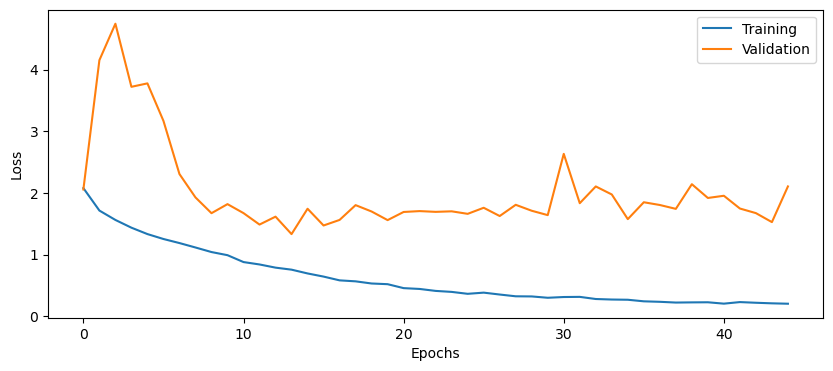

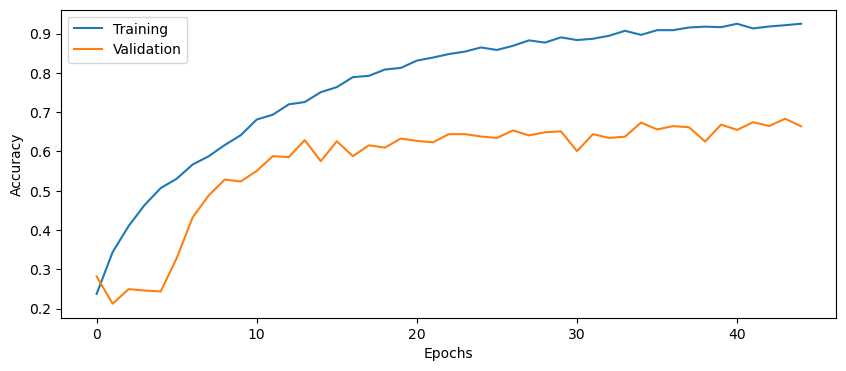

In [56]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 21: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

In [ ]:
# Q21
# The test accuracy for rotated test images are 0.24, which is much lower than original test.
# Rotated images change the distribution of pixel value.
# During the training, the images saw by model are without rotation.But in the test stage, the images are rotated,
# under such circumstance, the pixel distribution between training data and test data is different
# so the accuracy would also be different.

In [59]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

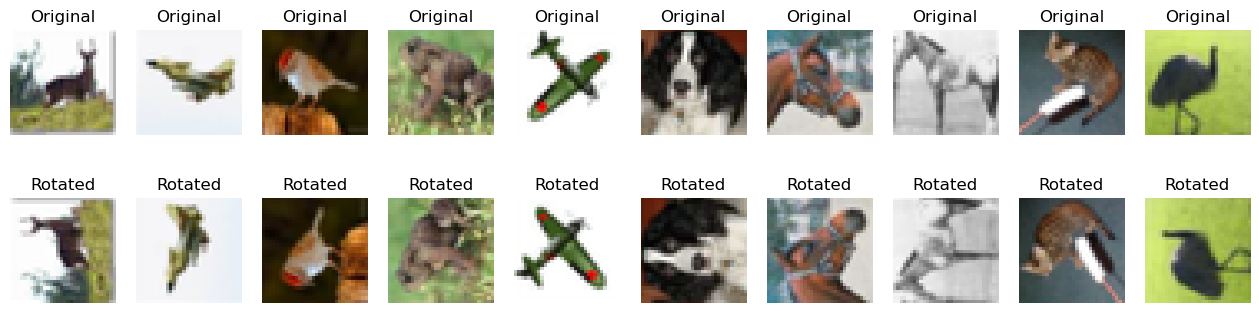

In [60]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [62]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(Xtest_rotated, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 9.8281
Test accuracy: 0.2415


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator , the .flow(x,y) functionality

In [63]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [84]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=30, horizontal_flip=True,vertical_flip=True,validation_split=0.2)

# Setup a flow for training data, assume that we can fit all images into CPU memory
train = datagen.flow(Xtrain, Ytrain, batch_size=128)
train_gen = datagen.flow(Xtrain, Ytrain, batch_size=batch_size, subset='training')

# Setup a flow for validation data, assume that we can fit all images into CPU memory
valid = datagen.flow(Xtrain, Ytrain, batch_size=128)
val_gen = datagen.flow(Xtrain, Ytrain, batch_size=batch_size, subset='validation')

## Part 18: What about big data?

Question 22: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

In [85]:
# Q22
# We can try another function 'flow_from_directory'. 
# Disadvantage: longer time needed.

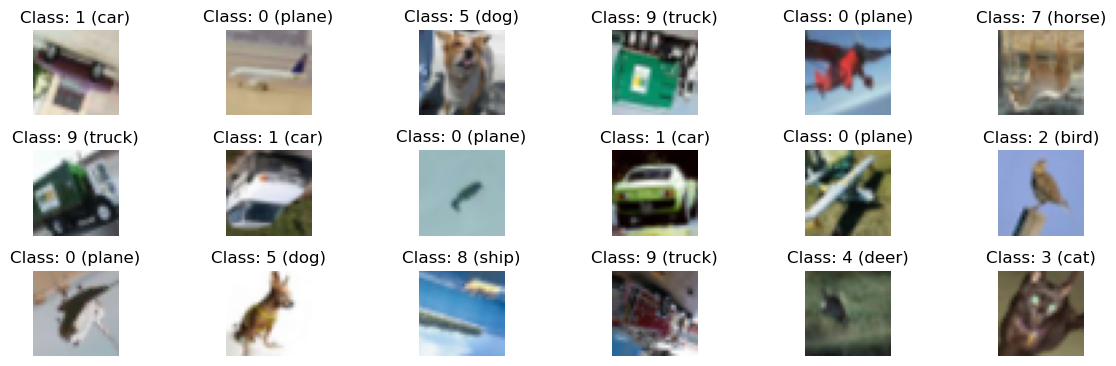

In [86]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/api/models/model_training_apis/#fit-method for how to use model.fit with a generator instead of a fix dataset (numpy arrays)

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 23: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

Question 24: What other types of image augmentation can be applied, compared to what we use here?

In [87]:
# Q23
# It become slower. 
# The reason is : now the data is more complex(with rotation), so there are more features that need to be concerned.
# We can increase number of epoch and also make model tobe more complex.

# Q24
# We can change the brightness, saturation， Contrast
# For some special dataset like underwater dataset, maybe we also need to reduce the blue.

In [89]:
# Setup some training parameters
batch_size = 128
epochs = 200
input_shape = Xtrain.shape

# Build model (your best config)
model6 = build_CNN(input_shape, n_conv_layers=5, n_filters=40, n_dense_layers=2, n_nodes=16, use_dropout=True, learning_rate=0.01)

validation_split=0.2
    
# Train the model using on the fly augmentation
history6 = model6.fit(train, steps_per_epoch=len(Xtrain)*(1 - validation_split)/batch_size, epochs=40,
                      validation_data = valid,validation_steps = len(Xtrain)*validation_split/batch_size) 

Epoch 1/40
62/62 [==============================] - 4s 44ms/step - loss: 2.4484 - accuracy: 0.1613 - val_loss: 2.4606 - val_accuracy: 0.1919
Epoch 2/40
62/62 [==============================] - 3s 41ms/step - loss: 2.0169 - accuracy: 0.2348 - val_loss: 2.8580 - val_accuracy: 0.1499
Epoch 3/40
62/62 [==============================] - 3s 42ms/step - loss: 1.8975 - accuracy: 0.2682 - val_loss: 4.2232 - val_accuracy: 0.1499
Epoch 4/40
62/62 [==============================] - 3s 41ms/step - loss: 1.8506 - accuracy: 0.2889 - val_loss: 2.9966 - val_accuracy: 0.1606
Epoch 5/40
62/62 [==============================] - 3s 41ms/step - loss: 1.7947 - accuracy: 0.3125 - val_loss: 2.4135 - val_accuracy: 0.2241
Epoch 6/40
62/62 [==============================] - 3s 41ms/step - loss: 1.7661 - accuracy: 0.3403 - val_loss: 2.2228 - val_accuracy: 0.2866
Epoch 7/40
62/62 [==============================] - 3s 41ms/step - loss: 1.7154 - accuracy: 0.3562 - val_loss: 2.1762 - val_accuracy: 0.2939
Epoch 8/40
62

In [90]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.4541
Test accuracy: 0.5410
Test loss: 2.4776
Test accuracy: 0.3020


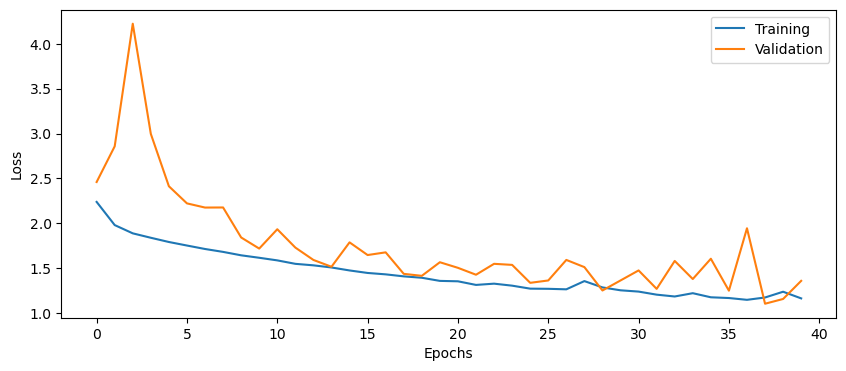

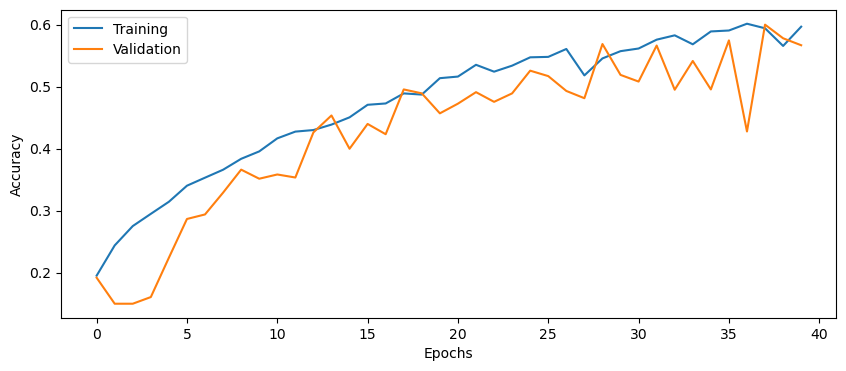

In [91]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly, these cells are already finished.

In [92]:
# Find misclassified images
y_pred=model6.predict(Xtest) 
y_pred=np.argmax(y_pred,axis=1)

y_correct = np.argmax(Ytest,axis=-1)

miss = np.flatnonzero(y_correct != y_pred)

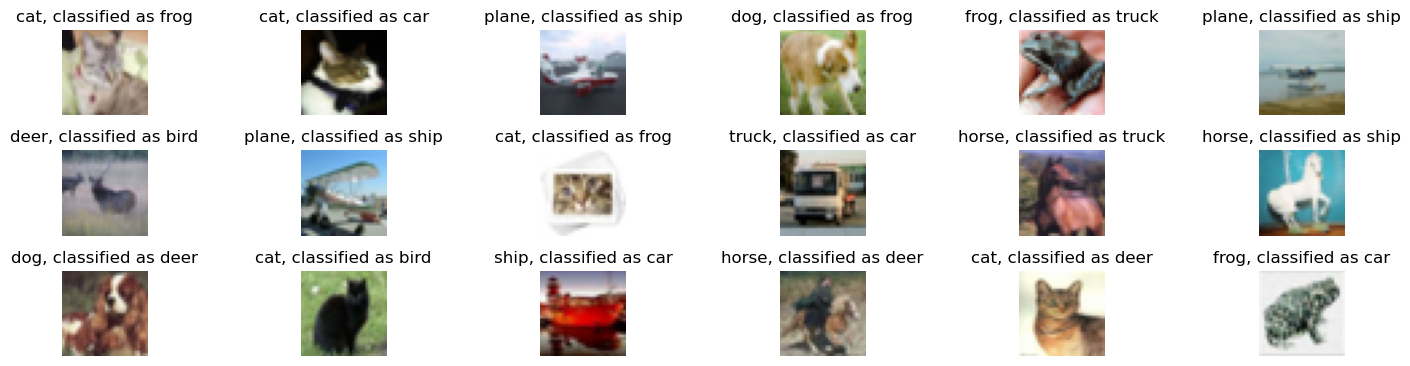

In [93]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 25: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

Question 26: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

In [ ]:
# Q25
# No. The fully connected layer requires fixed number of coefficients (it is liner combination).
# If the image size is changed, then the input can not fit the number of coefficients in fully connected layer.

# Q26
# Yes, we can resize the image into the shape of requirement.
# We can also use SPP-layer(spatial pyramid pooling), which can handle arbitrary size of input and generate fixed output size.

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database (several million images, 1000 classes). Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 27: How many convolutional layers does ResNet50 have? 

Question 28: How many trainable parameters does the ResNet50 network have? 

Question 29: What is the size of the images that ResNet50 expects as input?

Question 30: Using the answer to question 28, explain why the second derivative is seldom used when training deep networks.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine or your own computer. Are the predictions correct? How certain is the network of each image class?

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/api/applications/ and https://keras.io/api/applications/resnet/#resnet50-function 

Useful functions

`image.load_img` in tensorflow.keras.preprocessing

`image.img_to_array` in tensorflow.keras.preprocessing

`ResNet50` in tensorflow.keras.applications.resnet50

`preprocess_input` in tensorflow.keras.applications.resnet50

`decode_predictions` in tensorflow.keras.applications.resnet50

`expand_dims` in numpy


In [ ]:
# Q27
# 53

# Q28
# 25,583,592

# Q29 
# When parameter'include_top' = True, the expected size is 3*224*224 or 224*224*3
# When parameter'include_top' = False, we can put any size of image as long as it's bigger than 32*32 and exactly has 3 channels.

# Q30
# Because calculate second derivative need to store a huge matrix and take long time.

In [96]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice. 
# The preprocessing should transform the image to a size that is expected by the CNN.
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions  
from numpy import expand_dims

model = ResNet50(weights='imagenet')

img_path = ['train.jpg','ferrari_lego.jpg','car.jpg','bicycle.jpg','airplane.jpg']
target = ['steam_train','ferrari488_lego','Porsche911','bicycle','airplane']
res = []


for i in img_path:
    img = load_img(i, target_size=(224, 224))
    img = img_to_array(img)
    img = expand_dims(img, axis=0)
    img = preprocess_input(img)
    pre = model.predict(img)
    res.append(decode_predictions(pre, top=1)[0])
    
print('prediction:',res)
print("True label:",target)

The predict result: [[('n04310018', 'steam_locomotive', 0.9991659)], [('n04037443', 'racer', 0.6456276)], [('n04285008', 'sports_car', 0.808785)], [('n02835271', 'bicycle-built-for-two', 0.7387698)], [('n02690373', 'airliner', 0.84318006)]]
The target: ['steam_train', 'ferrari_lego', 'Porsche911', 'bicycle', 'airplane']


In [97]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________